In [3]:
import sys
sys.path.append('../src/')

from data_extraction import tools

In [4]:
%load_ext autoreload
%autoreload 2

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import glob
import mne
import re
import os
import pickle
import seaborn as sns

In [6]:
path = '../data/SubjectX1/headcast_subj01_sess01_EEG_data_cube-epo.fif'
data = mne.read_epochs(path)

Reading ../data/SubjectX1/headcast_subj01_sess01_EEG_data_cube-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =       0.00 ...    4000.00 ms
        0 CTF compensation matrices available
327 matching events found
No baseline correction applied
327 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


In [7]:
data.info

<Info | 18 non-empty fields
    bads : list | 0 items
    ch_names : list | 1, 2, 3, 4, 5, 6, 7, 8, 9, ...
    chs : list | 60 items (EEG: 60)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    file_id : dict | 4 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 250.0 Hz
    meas_date : NoneType | unspecified
    meas_id : dict | 4 items
    nchan : int | 60
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 500.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xplotter_layout : NoneType
>

In [97]:
def saperate_passive_active(epoch_array):
    events = epoch_array.events
    data_array = epoch_array.get_data()
    
    data_shape = data_array.shape
    active_indexes = []
    passive_indexes = []
    for i in range(len(events)):
        if events[i][2] == 1:
            active_indexes.append(i)
        if events[i][2] == 2:
            passive_indexes.append(i)
            
    return data_array[active_indexes, :, :], data_array[passive_indexes, :, :]

def sample_data_points(data, gap=300):
    data_shape = data.shape
    sampling_indexes = [index for index in range(0, data_shape[2], gap)]
    sampled_data = data[:, :, sampling_indexes].transpose(1,2,0).reshape(data_shape[1], -1)
    return sampled_data

def create_dataset(filepaths, verbose=0):
    temp_active = None
    temp_passive = None
    for path in filepaths:
        epochs = mne.read_epochs(path, verbose=verbose)
        active, passive = saperate_passive_active(epochs)
        sampled_active = sample_data_points(active)
        sampled_passive = sample_data_points(passive)
        if (temp_active is not None) and (temp_passive is not None):
            temp_active = np.hstack([temp_active, sampled_active])
            temp_passive = np.hstack([temp_passive, sampled_passive])
        else:
            temp_active = sampled_active
            temp_passive = sampled_passive
        
    return temp_active, temp_passive
        
def create_m(edges, dim):
    m = np.zeros((dim,dim))
    for edge in edges:
        m[edge[0], edge[1]] = 1
    return m

def read_in_graphs_sparsities(path_to_output, event_type):
    paths = []
    event_name = ''
    if event_type == 1:
        event_name = "btn"
    elif event_type == 2:
        event_name = "auto"
        
    for i in range(10):
        path = path_to_output + event_name + str(i+1) + '.pkl'
        paths.append(path)
    
    graphs = []
    
    for path in paths:
        with open(path, 'rb') as f:
            result = pickle.load(f)
        m = create_m(result['graph'].edges(), 60)
        graphs.append(m)
    
    return graphs

def fold_graph(m):
    m_shape = m.shape
    m = np.round(m)
    m_copy = m.copy()
    for i in range(m_shape[0]):
        for j in range(m_shape[1]):
            if i > j:
                if (m[i][j] != 1) & (m[j,i] != 0):
                    m_copy[i][i] = 1
                    m_copy[j][i] = 0
            elif i == j:
                m_copy[i][i] = 0
    return m_copy
    

In [98]:
LEFT_CH = [1, 4, 5, 8, 9, 10, 11, 17, 18, 19, 20, 25, 26, 27, 28, 29, 36, 37, 38, 39, 44, 45, 46, 47, 53, 54, 57];

RIGHT_CH = [3, 7, 6, 16, 15, 14, 13, 24, 23, 22, 21, 35, 34, 33, 32, 31, 43, 42, 41, 40, 52, 51, 50, 49, 56, 55, 59];

VER_MID_CH = [2, 12, 30, 48, 58, 60];

In [99]:
indexes = np.array(LEFT_CH + RIGHT_CH + VER_MID_CH) - 1

In [100]:
chs = LEFT_CH + RIGHT_CH + VER_MID_CH

# SubjectX1

In [101]:
data_mat = sorted(glob.glob('../data/SubjectX1/*.fif'))
data_mat

['../data/SubjectX1/headcast_subj01_sess01_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess02_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess03_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess04_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess05_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess06_EEG_data_cube-epo.fif',
 '../data/SubjectX1/headcast_subj01_sess07_EEG_data_cube-epo.fif']

In [102]:
active, passive = create_dataset(data_mat)

In [103]:
active = active[indexes]

In [104]:
passive = active[indexes]

In [105]:
graphs_active = read_in_graphs_sparsities('../data/graphs/subject1/active/', 1)

In [106]:
graphs_passive = read_in_graphs_sparsities('../data/graphs/subject1/passive/', 2)

In [107]:
corr_active = np.corrcoef(active)
corr_passive = np.corrcoef(passive)

In [108]:
corr_active

array([[ 1.        ,  0.58256371,  0.696844  , ..., -0.68119559,
        -0.62409368, -0.55124774],
       [ 0.58256371,  1.        ,  0.49005661, ..., -0.56617594,
        -0.54629296, -0.50037415],
       [ 0.696844  ,  0.49005661,  1.        , ..., -0.67086102,
        -0.67646032, -0.6038571 ],
       ...,
       [-0.68119559, -0.56617594, -0.67086102, ...,  1.        ,
         0.66870091,  0.52065694],
       [-0.62409368, -0.54629296, -0.67646032, ...,  0.66870091,
         1.        ,  0.93595836],
       [-0.55124774, -0.50037415, -0.6038571 , ...,  0.52065694,
         0.93595836,  1.        ]])

In [109]:
corr_active_u = np.triu(corr_active)


In [110]:
m_folded = fold_graph(graphs_active[0])

In [111]:
m_corr = corr_active_u + m_folded

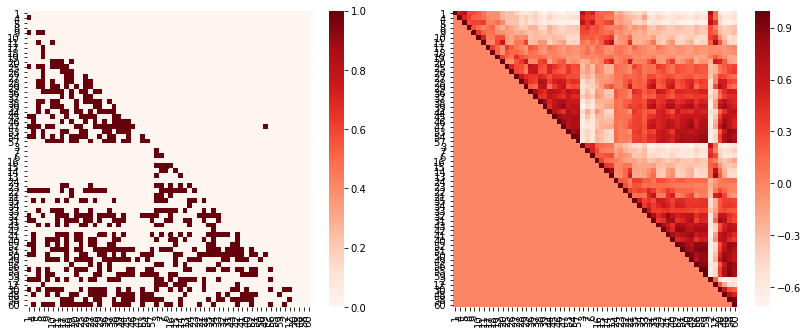

In [112]:
plt.rcParams["figure.figsize"] = (14,12)
plt.subplot(2, 2, 1)
sns.heatmap(m_folded, cmap='Reds', xticklabels=chs, yticklabels=chs)
plt.subplot(2, 2, 2)
sns.heatmap(corr_active_u, cmap='Reds', xticklabels=chs, yticklabels=chs)

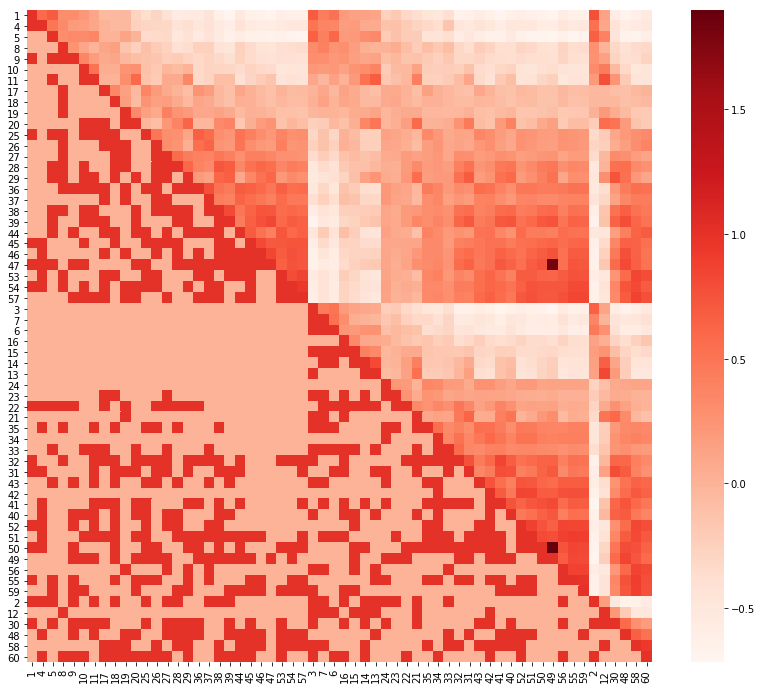

In [113]:
sns.heatmap(m_corr, cmap='Reds', xticklabels=chs, yticklabels=chs)

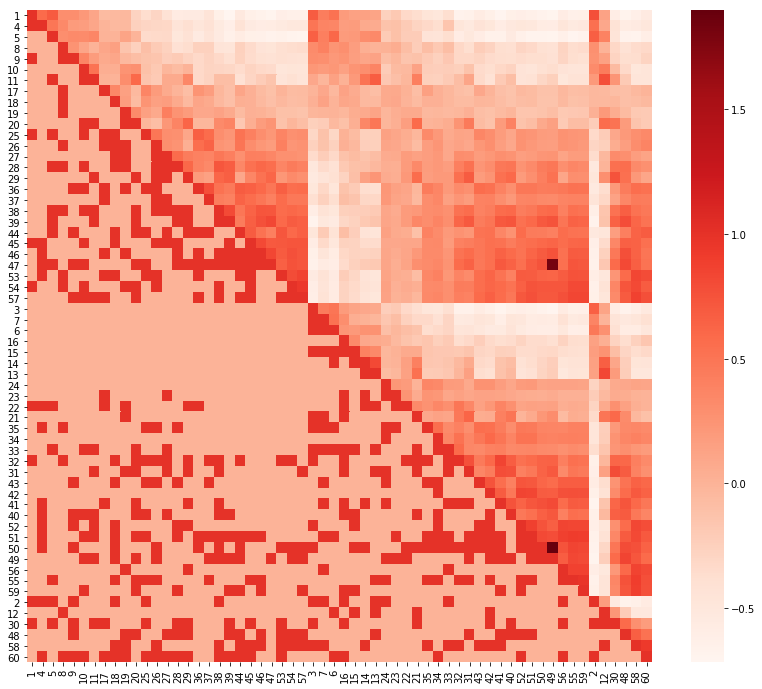

In [114]:
m_folded = fold_graph(graphs_active[1])
m_corr = corr_active_u + m_folded
sns.heatmap(m_corr, cmap='Reds', xticklabels=chs, yticklabels=chs)

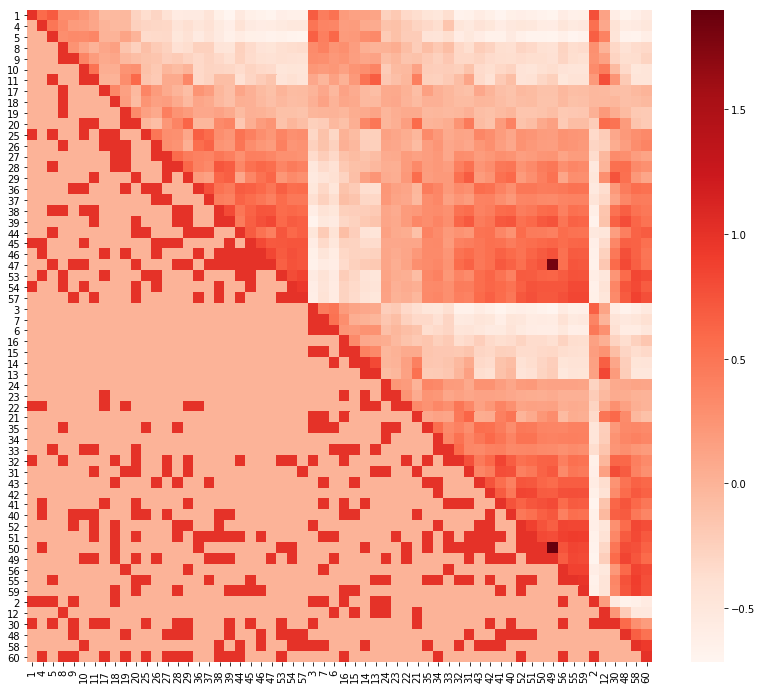

In [115]:
m_folded = fold_graph(graphs_active[2])
m_corr = corr_active_u + m_folded
sns.heatmap(m_corr, cmap='Reds', xticklabels=chs, yticklabels=chs)

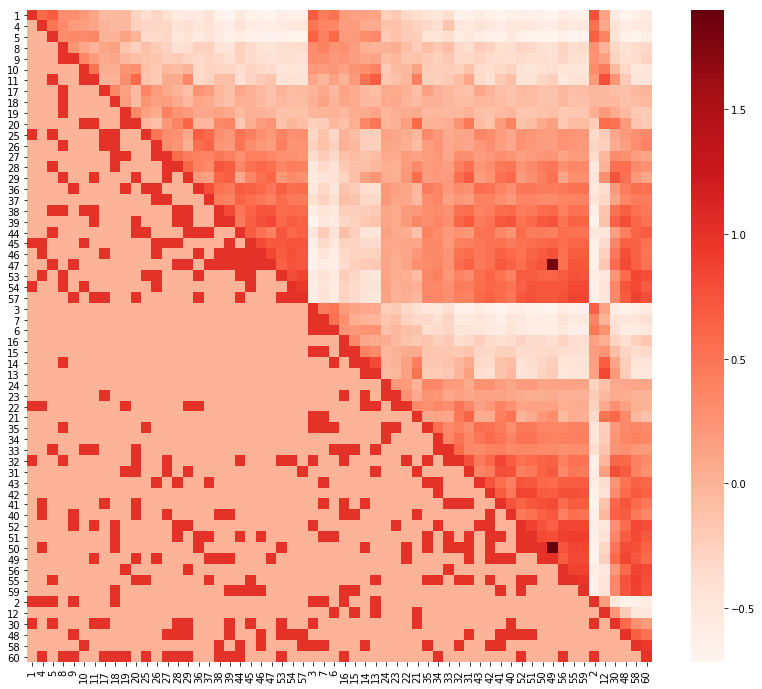

In [116]:
m_folded = fold_graph(graphs_active[3])
m_corr = corr_active_u + m_folded
sns.heatmap(m_corr, cmap='Reds', xticklabels=chs, yticklabels=chs)

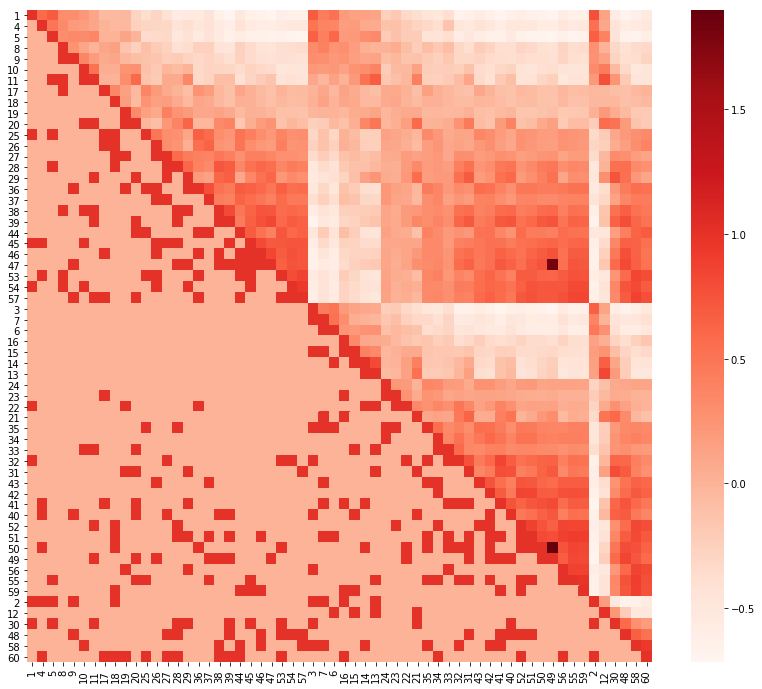

In [117]:
m_folded = fold_graph(graphs_active[4])
m_corr = corr_active_u + m_folded
sns.heatmap(m_corr, cmap='Reds', xticklabels=chs, yticklabels=chs)

# Subject1

In [13]:
data_mat = sorted(glob.glob('../data/Subject1/*.fif'))
data_mat

['../data/Subject1/subj01_sess02_EEG_data_cube_oc-epo.fif',
 '../data/Subject1/subj01_sess03_EEG_data_cube_oc-epo.fif',
 '../data/Subject1/subj01_sess04_EEG_data_cube_oc-epo.fif',
 '../data/Subject1/subj01_sess05_EEG_data_cube_oc-epo.fif']

In [14]:
active, passive = create_dataset(data_mat)

In [15]:
active.shape

(60, 7328)

In [16]:
passive.shape

(60, 3072)